In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os 
import wave
from PIL import Image
from tensorflow.keras.applications.resnet50 import preprocess_input
from io import BytesIO
from scipy.io import wavfile
from scipy.signal import spectrogram

.\OAF_angry


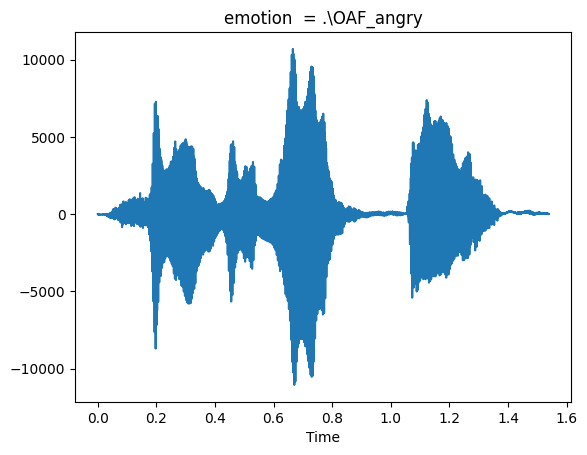

.\OAF_Fear


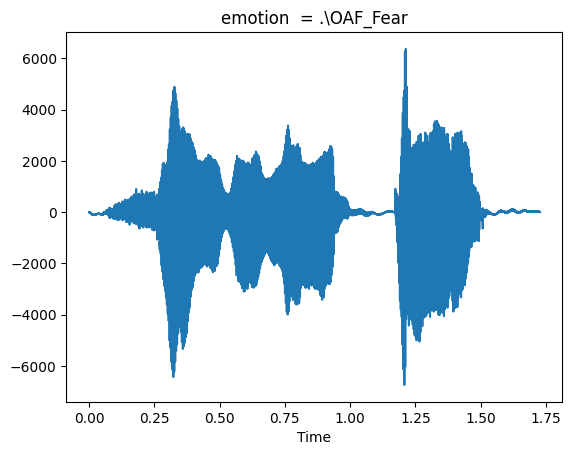

.\OAF_happy


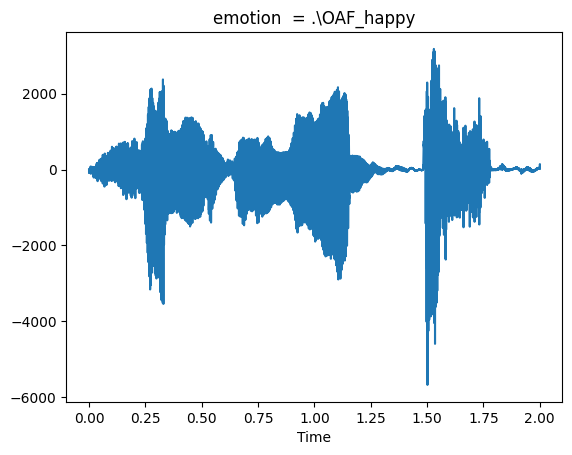

In [20]:

for root, dirs, files in os.walk('.'):
    if root == '.':
        continue
    print(root)
    for file in files[:1]:
        raw = wave.open(os.path.join(root, file))
      

        signal = raw.readframes(-1) 
        signal = np.frombuffer(signal, dtype ="int16") 
        
        # gets the frame rate 
        f_rate = raw.getframerate() 

        time = np.linspace( 
            0, # start 
            len(signal) / f_rate, 
            num = len(signal) 
        ) 
    
        # using matplotlib to plot 
        # creates a new figure 
        plt.figure(1) 
        
        # title of the plot 
        plt.title(f"emotion  = {root}") 
        
        # label of x-axis 
        plt.xlabel("Time") 
        
        # actual plotting 
        plt.plot(time, signal) 
        
        # shows the plot  
        # in new window 
        plt.show() 
    

### CREATING THE IMAGES FOR CNN

In [23]:


def save_spectrogram(input_path, output_path):
    sample_rate, samples = wavfile.read(input_path)
    f, t, Sxx = spectrogram(samples, fs=sample_rate)
    
    fig = plt.figure()
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.savefig(output_path, format='png', bbox_inches='tight', pad_inches=0)
    plt.close(fig) 

In [ ]:
# cnn modeline uygun bir şekilde kaydetmek için axislerin olmadığı bir şekilde kaydetmemiz gerekiyor.
def save_plot(x,y,save_path):
    fig, ax = plt.subplots()
    ax.plot(x, y)

    # Remove axis, ticks, labels
    ax.axis('off')

    # Save without extra borders
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close()


In [24]:
for root, dirs, files in os.walk('.'):
    if root == '.':
        continue

    os.makedirs(root+"_images", exist_ok=True) # her duygu için yeni bir klasör açıyoruz.
    for file in files:
        save_spectrogram(os.path.join(root, file), os.path.join(root+"_images", file.split(".")[0]+".png"))
    

In [4]:

### RESNET50 PREPROCESSING ###
# 224 x 224 boyutunda ve RGB formatında input bekliyor.
image_size = (224, 224) 
image_data = []
labels = []

for root, dirs, files in os.walk('.'):
    if not root.endswith('_images'):
        continue

    label = os.path.basename(root).replace('_images', '')

    for file in files:
        if not file.endswith('.png'):
            continue

        img_path = os.path.join(root, file)

      
        img = Image.open(img_path).convert('RGB')
        img = img.resize(image_size)
        img_array = np.array(img).astype('float32')

        # Preprocess for ResNet50
        img_array = preprocess_input(img_array)

        image_data.append(img_array)
        labels.append(label)

X = np.array(image_data)
y = np.array(labels)

print("X shape:", X.shape)  # (num_samples, 224, 224, 3 (rgb input))
print("y shape:", y.shape)


X shape: (600, 224, 224, 3)
y shape: (600,)


In [5]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_onehot = to_categorical(y_encoded)


base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(y_onehot.shape[1], activation='softmax')(x)

tf_model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False

# Compile
tf_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y_onehot, 
    test_size=0.2,      
    random_state=42)  


In [7]:
history = tf_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)



Epoch 1/10
15/15 [==============================] - 25s 1s/step - loss: 0.8785 - accuracy: 0.5604 - val_loss: 0.5351 - val_accuracy: 0.7833
Epoch 2/10
15/15 [==============================] - 21s 1s/step - loss: 0.3889 - accuracy: 0.8687 - val_loss: 0.2994 - val_accuracy: 0.8917
Epoch 3/10
15/15 [==============================] - 21s 1s/step - loss: 0.2048 - accuracy: 0.9458 - val_loss: 0.1637 - val_accuracy: 0.9583
Epoch 4/10
15/15 [==============================] - 20s 1s/step - loss: 0.1341 - accuracy: 0.9708 - val_loss: 0.1416 - val_accuracy: 0.9750
Epoch 5/10
15/15 [==============================] - 21s 1s/step - loss: 0.0904 - accuracy: 0.9812 - val_loss: 0.0972 - val_accuracy: 0.9917
Epoch 6/10
15/15 [==============================] - 20s 1s/step - loss: 0.0661 - accuracy: 0.9896 - val_loss: 0.0853 - val_accuracy: 0.9917
Epoch 7/10
15/15 [==============================] - 20s 1s/step - loss: 0.0557 - accuracy: 0.9896 - val_loss: 0.0818 - val_accuracy: 0.9833
Epoch 8/10
15/15 [==

### CREATING NEW TEST DATA WITH LLM

In [1]:
from transformers import AutoProcessor, AutoModel,pipeline,BarkModel
import scipy
import numpy as np 

processor = AutoProcessor.from_pretrained("suno/bark")
model = BarkModel.from_pretrained("suno/bark")
text = "Nice to meet you .[laughter]"

inputs = processor(text, voice_preset="v2/en_speaker_6")
audio_array = model.generate(**inputs)
audio_array = audio_array.cpu().numpy().squeeze()
sample_rate = model.generation_config.sample_rate
scipy.io.wavfile.write("bark_out.wav",rate=sample_rate, data=audio_array)


c:\Users\ozcan\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\models\encodec\modeling_encodec.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("padding_total", torch.tensor(kernel_size - stride, dtype=torch.int64), persistent=False)


en_speaker_6_semantic_prompt.npy:   0%|          | 0.00/2.60k [00:00<?, ?B/s]

en_speaker_6_coarse_prompt.npy:   0%|          | 0.00/7.55k [00:00<?, ?B/s]

en_speaker_6_fine_prompt.npy:   0%|          | 0.00/15.0k [00:00<?, ?B/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:10000 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


In [8]:
def preprocess_audio_input(input_path):
    image_size = (224, 224)  # ResNet50 input size
    # Read audio
    sample_rate, samples = wavfile.read(input_path)
    f, t, Sxx = spectrogram(samples, fs=sample_rate)

    # Plot spectrogram to an in-memory buffer
    fig = plt.figure(figsize=(2.24, 2.24), dpi=100)  # Optional: control size
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    plt.axis('off')
    plt.tight_layout(pad=0)


    buf = BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    buf.seek(0)

    image = Image.open(buf).convert('RGB')
    img = image.resize(image_size)
    img_array = np.array(img).astype('float32')

        # Preprocess for ResNet50
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)  # Shape: (1, 224, 224, 3)

    return img_array  # Shape: (H, W, 3)

In [9]:
a = preprocess_audio_input("bark_out.wav")
le.inverse_transform([np.argmax(tf_model.predict(a))])

1/1 [==============================] - 1s 792ms/step


array(['OAF_happy'], dtype='<U9')

In [ ]:
y

1/1 [==============================] - 0s 78ms/step


array(['OAF_Fear'], dtype='<U9')

In [ ]:
def wav_to_image_array(wav_path, image_size=(224, 224)):
    # Load and process audio
    raw = wave.open(wav_path)
    signal = raw.readframes(-1)
    signal = np.frombuffer(signal, dtype='int16')
    f_rate = raw.getframerate()

    time = np.linspace(0, len(signal) / f_rate, num=len(signal))

    # Plot waveform without axis
    fig, ax = plt.subplots()
    ax.plot(time, signal)
    ax.axis('off')
    fig.tight_layout(pad=0)

    # Save plot to an in-memory image (no disk I/O)
    from io import BytesIO
    buf = BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    buf.seek(0)

    # Open image with PIL, resize, convert to array
    img = Image.open(buf).convert('RGB')
    img = img.resize(image_size)
    img_array = np.array(img).astype('float32')
    img_array = preprocess_input(img_array)  # ResNet50 specific
    buf.close()

    return img_array


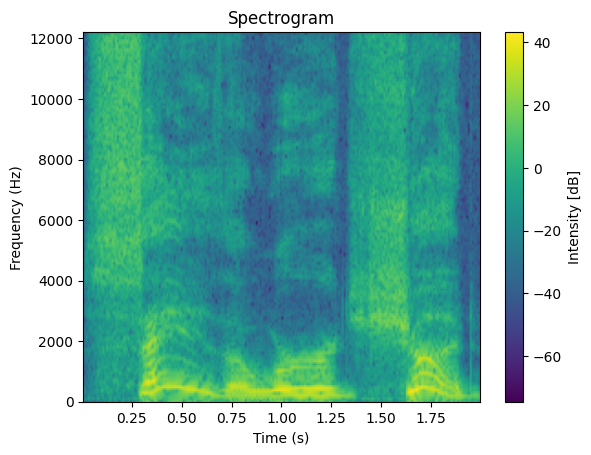

In [43]:
new_wav_path = "OAF_happy\OAF_should_happy.wav"

from scipy.io import wavfile
from scipy.signal import spectrogram

def plot_spectrogram(path):
    sample_rate, samples = wavfile.read(path)
    f, t, Sxx = spectrogram(samples, fs=sample_rate)
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')  # Convert to dB
    plt.title("Spectrogram")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.colorbar(label='Intensity [dB]')
    plt.show()

plot_spectrogram(new_wav_path)

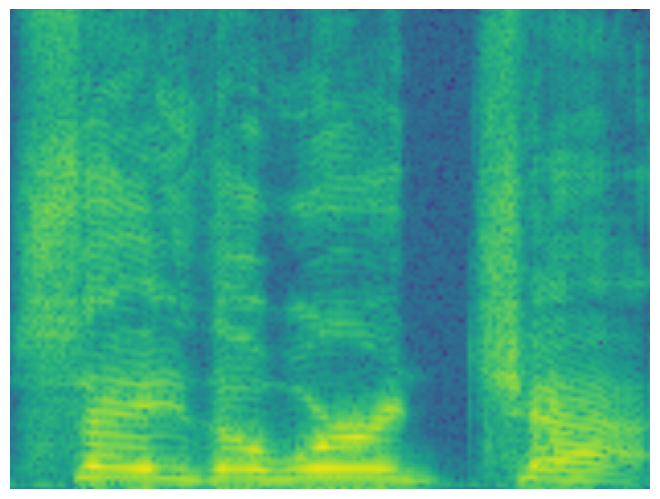

In [17]:
new_wav_path = "OAF_angry\OAF_chat_angry.wav"

from scipy.io import wavfile
from scipy.signal import spectrogram

def plot_spectrogram(path):
    sample_rate, samples = wavfile.read(path)
    f, t, Sxx = spectrogram(samples, fs=sample_rate)
    
    plt.figure()
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    
    # Remove axes and colorbar
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.savefig("deneme.png", format='png', bbox_inches='tight', pad_inches=0)
    
 

plot_spectrogram(new_wav_path)

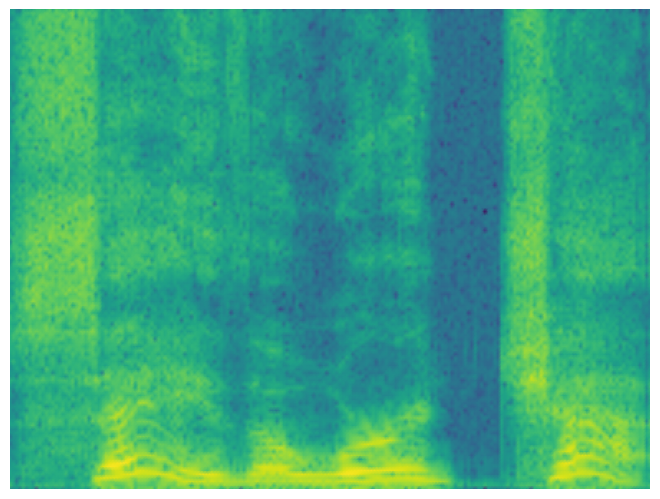

In [9]:
new_wav_path = "OAF_happy\OAF_chat_happy.wav"

from scipy.io import wavfile
from scipy.signal import spectrogram

def plot_spectrogram(path):
    sample_rate, samples = wavfile.read(path)
    f, t, Sxx = spectrogram(samples, fs=sample_rate)
    
    plt.figure()
    plt.pcolormesh(t, f, 10 * np.log10(Sxx),shading='gouraud')
    
    # Remove axes and colorbar
    plt.axis('off')
    plt.tight_layout(pad=0)
    
    plt.show()

plot_spectrogram(new_wav_path)

In [ ]:
for root, dirs, files in os.walk('.'):
    if root == '.':
        continue

    os.makedirs(root+"_images", exist_ok=True) # her duygu için yeni bir klasör açıyoruz.
    for file in files:
        raw = wave.open(os.path.join(root, file))
      

        signal = raw.readframes(-1) 
        signal = np.frombuffer(signal, dtype ="int16") 
        
        # gets the frame rate 
        f_rate = raw.getframerate() 

        time = np.linspace( 
            0, 
            len(signal) / f_rate, 
            num = len(signal) 
        ) 
        save_plot(time, signal, os.path.join(root+"_images", file.split(".")[0]+".png"))
    